In [1]:
import nasdaqdatalink
import dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


dotenv.load_dotenv('../../.env')

nasdaq_api_key = dotenv.get_key(dotenv.find_dotenv(), "NASDAQ_DATA_LINK_API_KEY")

### Wheat Options

In [2]:
# ── 1. Re-use the data already fetched (first 10000 rows) ──────────────────
#    nasdaqdatalink.get_table("AR/IVM") without paginate=True returns up to
#    10000 rows. We already have that in the previous cell output.
#    Re-fetch with a date filter to get a manageable single-contract series.

df_raw = nasdaqdatalink.get_table("AR/IVM", futures_code="W")
print(f"Rows fetched: {len(df_raw)}")
print(f"Columns: {list(df_raw.columns)}")
print(f"Expirations: {sorted(df_raw['expiration'].unique())}")


Rows fetched: 10000
Columns: ['exchange_code', 'futures_code', 'option_code', 'expiration', 'date', 'futures', 'atm', 'rr25', 'rr10', 'fly25', 'fly10', 'beta1', 'beta2', 'beta3', 'beta4', 'beta5', 'beta6', 'min_money', 'max_money', 'days_expiration', 'days_termination']
Expirations: ['V2018', 'V2019', 'V2020', 'V2021', 'V2022', 'V2023', 'V2024', 'V2025', 'V2026', 'V2027', 'V2028', 'Z2011', 'Z2012', 'Z2013', 'Z2014', 'Z2015', 'Z2016', 'Z2017', 'Z2018', 'Z2019', 'Z2020', 'Z2021', 'Z2022', 'Z2023', 'Z2024', 'Z2025', 'Z2026', 'Z2027']


c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\nasdaqdatalink\get_table.py:38: UserWarning: To request more pages, please set paginate=True in your         nasdaqdatalink.get_table() call. For more information see our documentation:         https://github.com/Nasdaq/data-link-python/blob/main/FOR_ANALYSTS.md#things-to-note
  warnings.warn(Message.WARN_PAGE_LIMIT_EXCEEDED, UserWarning)


In [3]:

# ── 2. Build a continuous front-month futures price series ─────────────────
#    For each date, use the expiration with smallest days_expiration > 30
#    (avoid last month distortions). This gives a "rolling front-month" series.

df = df_raw.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["date", "days_expiration"])

# Pick "front month": smallest days_expiration that is > 30 days
front = (
    df[df["days_expiration"] > 30]
    .groupby("date")
    .first()          # first row per date = smallest days_expiration > 30
    .reset_index()
)
front = front.sort_values("date").dropna(subset=["futures", "atm"])
print(f"Front-month series: {len(front)} days, {front['date'].min().date()} → {front['date'].max().date()}")

# ── 3. Compute Realized Volatility from FUTURES log-returns ────────────────
#    RV is ALWAYS computed from the underlying futures price.
#    IV ('atm') already IS the Black-76 implied vol → no BS needed.

WINDOW = 21   # 21 trading days ≈ 1 month

front["log_ret"] = np.log(front["futures"] / front["futures"].shift(1))
front["RV_21d"]  = front["log_ret"].rolling(WINDOW).std() * np.sqrt(252)

# ── 4. VRP signal ──────────────────────────────────────────────────────────
#    VRP > 0  →  IV > RV  →  options are "expensive"  →  SELL vol
#    VRP < 0  →  IV < RV  →  options are "cheap"      →  BUY  vol

front["VRP"] = front["atm"] - front["RV_21d"]

print(front[["date", "futures", "atm", "RV_21d", "VRP"]].dropna().tail(15).to_string(index=False))
print(f"\nMean VRP : {front['VRP'].dropna().mean():.4f}")
print(f"% days IV > RV: {(front['VRP'].dropna() > 0).mean()*100:.1f}%")


Front-month series: 3771 days, 2010-12-31 → 2026-02-26
      date  futures      atm   RV_21d      VRP
2026-02-06    400.0 0.192249 0.156412 0.035837
2026-02-09    405.1 0.191700 0.164465 0.027235
2026-02-10    400.0 0.191918 0.168887 0.023031
2026-02-11    396.6 0.192486 0.169815 0.022671
2026-02-12    393.7 0.182503 0.169779 0.012724
2026-02-13    393.5 0.182525 0.168269 0.014256
2026-02-16    399.9 0.182903 0.162751 0.020152
2026-02-17    395.6 0.182421 0.165117 0.017304
2026-02-18    401.4 0.182773 0.172699 0.010074
2026-02-19    398.7 0.182699 0.173551 0.009148
2026-02-20    403.2 0.182408 0.174387 0.008021
2026-02-23    405.4 0.183432 0.171448 0.011984
2026-02-24    405.0 0.183238 0.171393 0.011845
2026-02-25    405.0 0.183266 0.171323 0.011943
2026-02-26    404.9 0.178404 0.171152 0.007252

Mean VRP : 0.0073
% days IV > RV: 62.1%


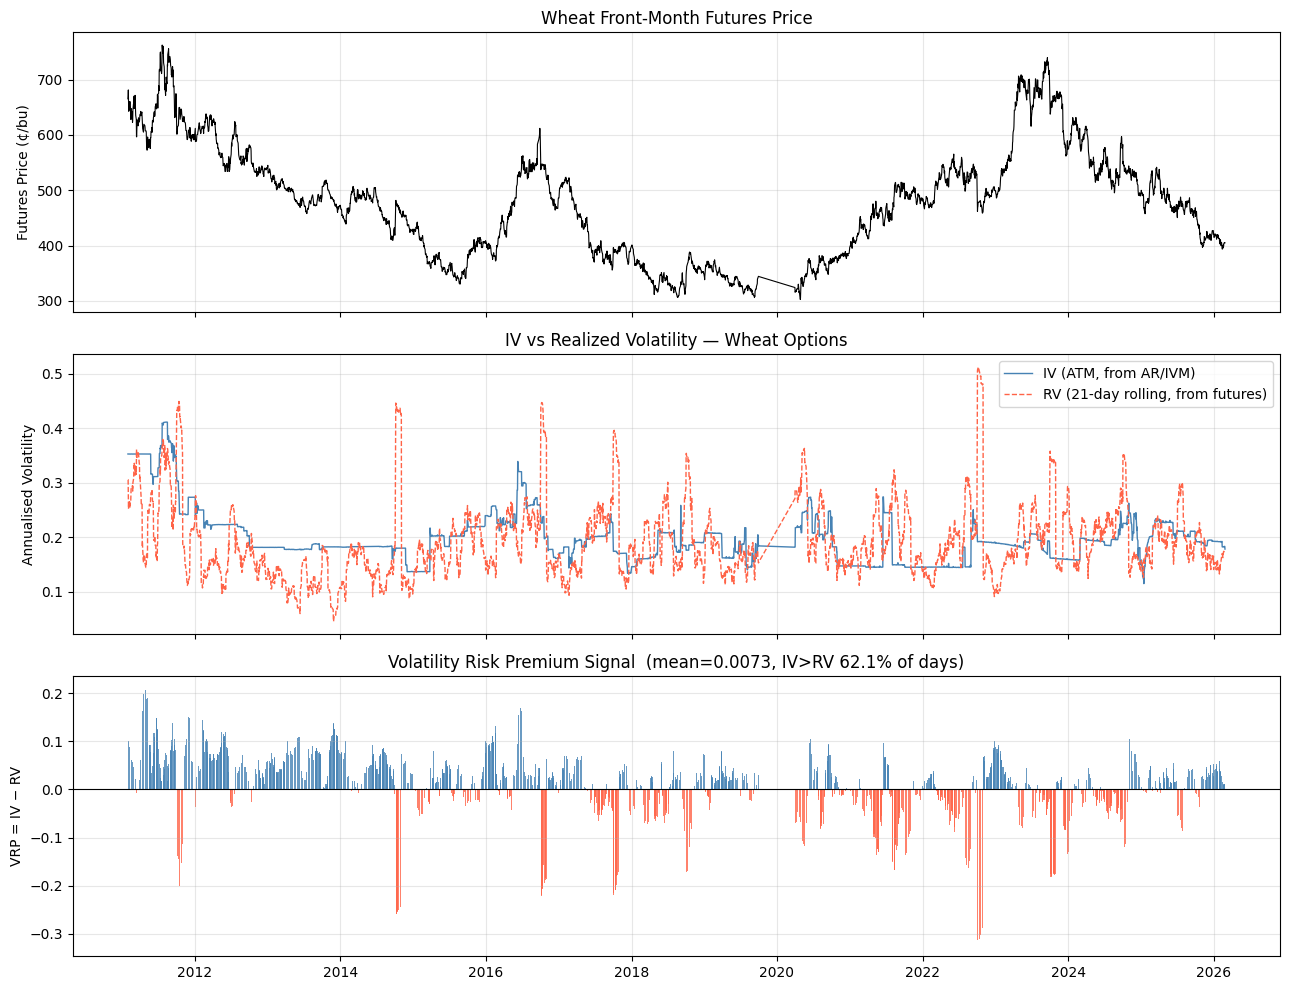

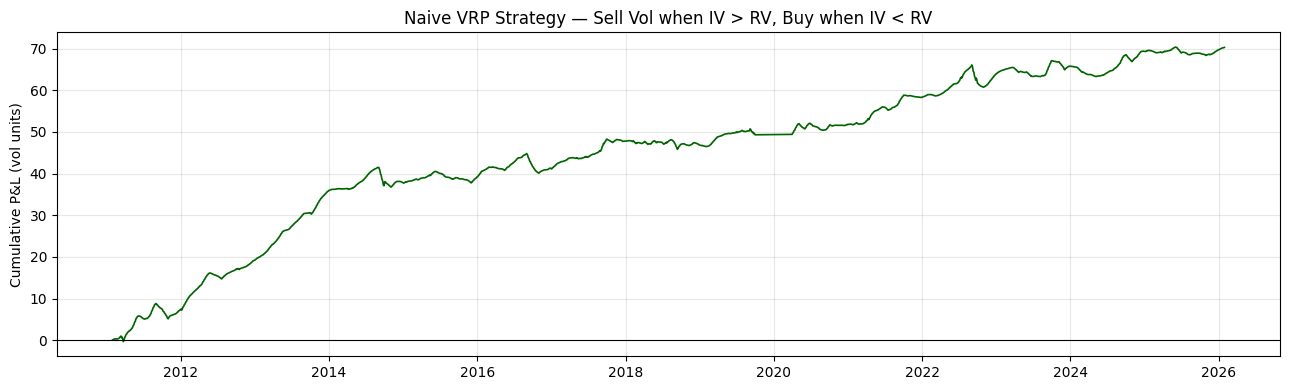

Mean daily P&L: 0.018851
Approx Sharpe:  4.58


In [4]:

# ── 5. Plot IV vs RV and VRP signal ───────────────────────────────────────
plot_df = front.dropna(subset=["RV_21d", "VRP"]).copy()

fig, axes = plt.subplots(3, 1, figsize=(13, 10), sharex=True)

# Panel 1: Futures price
axes[0].plot(plot_df["date"], plot_df["futures"], color="black", linewidth=0.8)
axes[0].set_ylabel("Futures Price (¢/bu)")
axes[0].set_title("Wheat Front-Month Futures Price")
axes[0].grid(alpha=0.3)

# Panel 2: IV vs RV
axes[1].plot(plot_df["date"], plot_df["atm"],    label="IV (ATM, from AR/IVM)", color="steelblue", linewidth=1)
axes[1].plot(plot_df["date"], plot_df["RV_21d"], label="RV (21-day rolling, from futures)", color="tomato", linewidth=1, linestyle="--")
axes[1].set_ylabel("Annualised Volatility")
axes[1].set_title("IV vs Realized Volatility — Wheat Options")
axes[1].legend()
axes[1].grid(alpha=0.3)

# Panel 3: VRP = IV - RV
colors = np.where(plot_df["VRP"] > 0, "steelblue", "tomato")
axes[2].bar(plot_df["date"], plot_df["VRP"], color=colors, width=1.5, alpha=0.8)
axes[2].axhline(0, color="black", linewidth=0.8)
axes[2].set_ylabel("VRP = IV − RV")
axes[2].set_title(f"Volatility Risk Premium Signal  (mean={plot_df['VRP'].mean():.4f}, IV>RV {(plot_df['VRP']>0).mean()*100:.1f}% of days)")
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ── 6. Naive backtest: sell ATM straddle whenever VRP > threshold ──────────
#    P&L proxy: at each period t, you sold vol at IV_t and realised RV_{t+21d}
#    Profit ≈ (IV_t - forward_RV) per unit of vega

THRESHOLD = 0.00   # sell whenever IV > RV (VRP > 0)

plot_df["forward_RV"] = plot_df["log_ret"].rolling(WINDOW).std().shift(-WINDOW) * np.sqrt(252)
plot_df["signal"]     = np.where(plot_df["VRP"] > THRESHOLD, -1, 1)   # -1=short vol, +1=long vol
plot_df["pnl"]        = plot_df["signal"] * (plot_df["forward_RV"] - plot_df["atm"])  # short vol profits when IV > realised

plot_df["cum_pnl"] = plot_df["pnl"].cumsum()

fig2, ax = plt.subplots(figsize=(13, 4))
ax.plot(plot_df["date"], plot_df["cum_pnl"], color="darkgreen", linewidth=1.2)
ax.axhline(0, color="black", linewidth=0.8)
ax.set_ylabel("Cumulative P&L (vol units)")
ax.set_title("Naive VRP Strategy — Sell Vol when IV > RV, Buy when IV < RV")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

sharpe = plot_df["pnl"].dropna().mean() / plot_df["pnl"].dropna().std() * np.sqrt(252)
print(f"Mean daily P&L: {plot_df['pnl'].dropna().mean():.6f}")
print(f"Approx Sharpe:  {sharpe:.2f}")


In [5]:

# ── Explore data structure ────────────────────────────────────────────────

print("=== df_raw Overview ===")
print(f"Total rows   : {len(df_raw)}")
print(f"Total columns: {len(df_raw.columns)}")
print()

# Number of records and date range for each expiration contract
exp_info = (
    df_raw.assign(date=pd.to_datetime(df_raw["date"]))
    .groupby("expiration")
    .agg(
        n_days   = ("date", "count"),
        date_min = ("date", "min"),
        date_max = ("date", "max"),
    )
    .sort_values("date_min")
)
exp_info["date_min"] = exp_info["date_min"].dt.date
exp_info["date_max"] = exp_info["date_max"].dt.date
print("=== Coverage by Expiration ===")
print(exp_info.to_string())
print(f"\nTotal unique expirations: {len(exp_info)}")


=== df_raw Overview ===
Total rows   : 10000
Total columns: 21

=== Coverage by Expiration ===
            n_days    date_min    date_max
expiration                                
Z2011          213  2010-12-31  2011-10-31
Z2012          394  2011-04-19  2012-10-30
Z2013          398  2012-04-16  2013-10-30
Z2014          398  2013-04-16  2014-10-30
Z2015          398  2014-04-16  2015-10-30
Z2016          399  2015-04-16  2016-10-31
Z2017          375  2016-05-20  2017-10-31
V2018          330  2017-05-23  2018-08-31
Z2018          213  2018-01-05  2018-10-31
V2019          391  2018-02-14  2019-08-29
Z2019          393  2018-04-16  2019-10-31
V2020          107  2020-03-31  2020-08-31
Z2020          151  2020-03-31  2020-10-30
V2021          354  2020-04-16  2021-08-31
Z2021          397  2020-04-16  2021-10-29
V2022          390  2021-02-16  2022-08-31
Z2022          391  2021-04-16  2022-10-31
V2023          334  2022-05-19  2023-08-31
Z2023          377  2022-05-19  2023-10-31
Z2

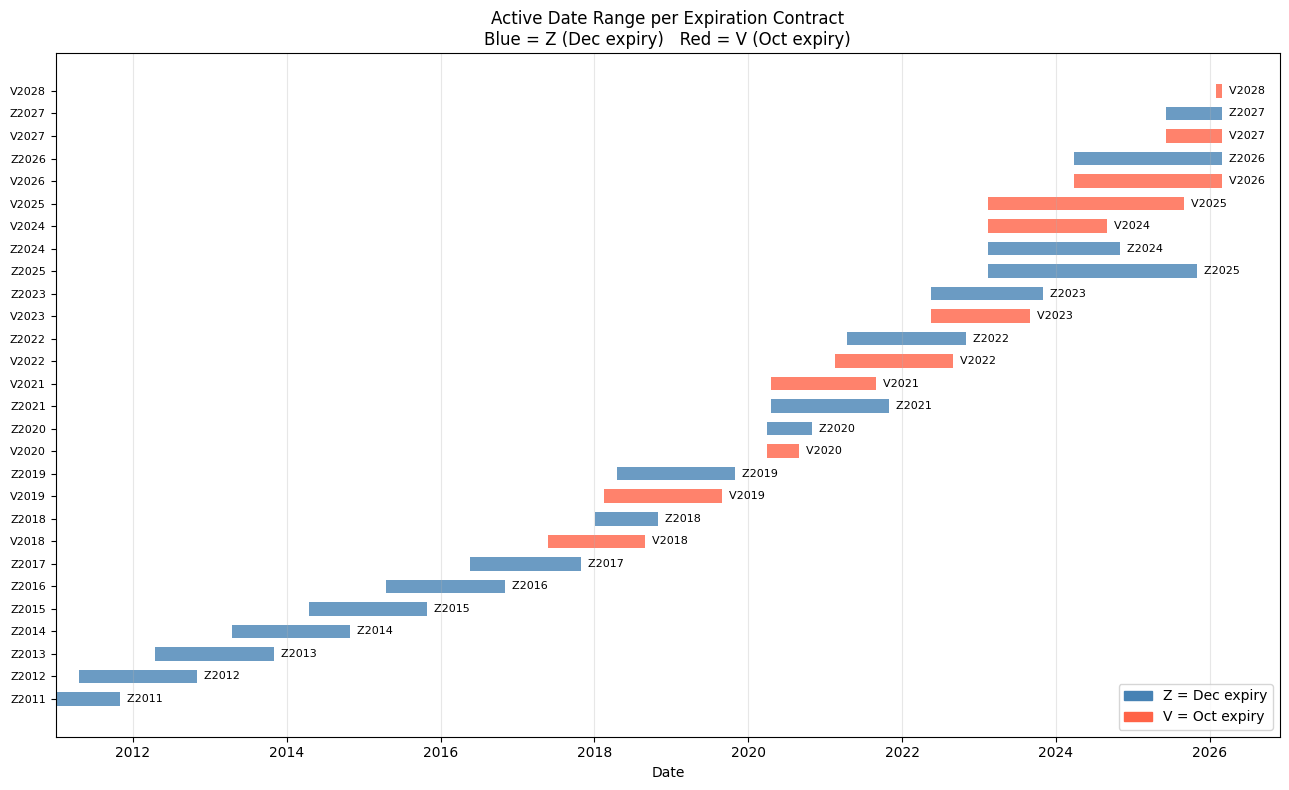


=== Price Jumps at Front-Month Contract Rolls ===
      date expiration_prev expiration  futures_prev  futures  jump
2010-12-31            None      Z2011           NaN    614.8   NaN
2011-10-03           Z2011      Z2012         663.3    608.8 -54.5
2012-10-02           Z2012      Z2013         582.1    577.2  -4.9
2013-10-02           Z2013      Z2014         488.7    506.8  18.1
2014-10-06           Z2014      Z2015         428.4    480.9  52.5
2015-10-05           Z2015      Z2016         384.0    377.3  -6.7
2016-10-03           Z2016      Z2017         597.2    537.2 -60.0
2017-10-02           Z2017      V2018         362.2    396.2  34.0
2018-08-06           V2018      Z2018         324.3    325.5   1.2
2018-10-02           Z2018      V2019         327.2    346.3  19.1
2019-08-05           V2019      Z2019         323.7    327.7   4.0
2020-03-31           Z2019      V2020         344.0    324.0 -20.0
2020-08-03           V2020      Z2020         381.6    373.9  -7.7
2020-10-05 

In [6]:

# ── Visualise the active date range of each expiration contract ───────────

fig, ax = plt.subplots(figsize=(13, 8))

exp_sorted = exp_info.sort_values("date_min")
for i, (exp, row) in enumerate(exp_sorted.iterrows()):
    color = "steelblue" if exp.startswith("Z") else "tomato"
    ax.barh(i, (pd.Timestamp(row["date_max"]) - pd.Timestamp(row["date_min"])).days,
            left=pd.Timestamp(row["date_min"]), height=0.6, color=color, alpha=0.8)
    ax.text(pd.Timestamp(row["date_max"]), i, f"  {exp}", va="center", fontsize=8)

ax.set_yticks(range(len(exp_sorted)))
ax.set_yticklabels(exp_sorted.index, fontsize=8)
ax.set_xlabel("Date")
ax.set_title("Active Date Range per Expiration Contract\nBlue = Z (Dec expiry)   Red = V (Oct expiry)")

from matplotlib.patches import Patch
ax.legend(handles=[Patch(color="steelblue", label="Z = Dec expiry"),
                   Patch(color="tomato",    label="V = Oct expiry")], loc="lower right")
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

# ── Check for price jumps at front-month roll dates ───────────────────────
print("\n=== Price Jumps at Front-Month Contract Rolls ===")
front2 = front.copy()
front2["expiration_prev"] = front2["expiration"].shift(1)
# Identify roll dates
switches = front2[front2["expiration"] != front2["expiration_prev"]].copy()
switches["futures_prev"] = front2["futures"].shift(1)
switches["jump"] = switches["futures"] - switches["futures_prev"]
print(switches[["date", "expiration_prev", "expiration", "futures_prev", "futures", "jump"]].to_string(index=False))


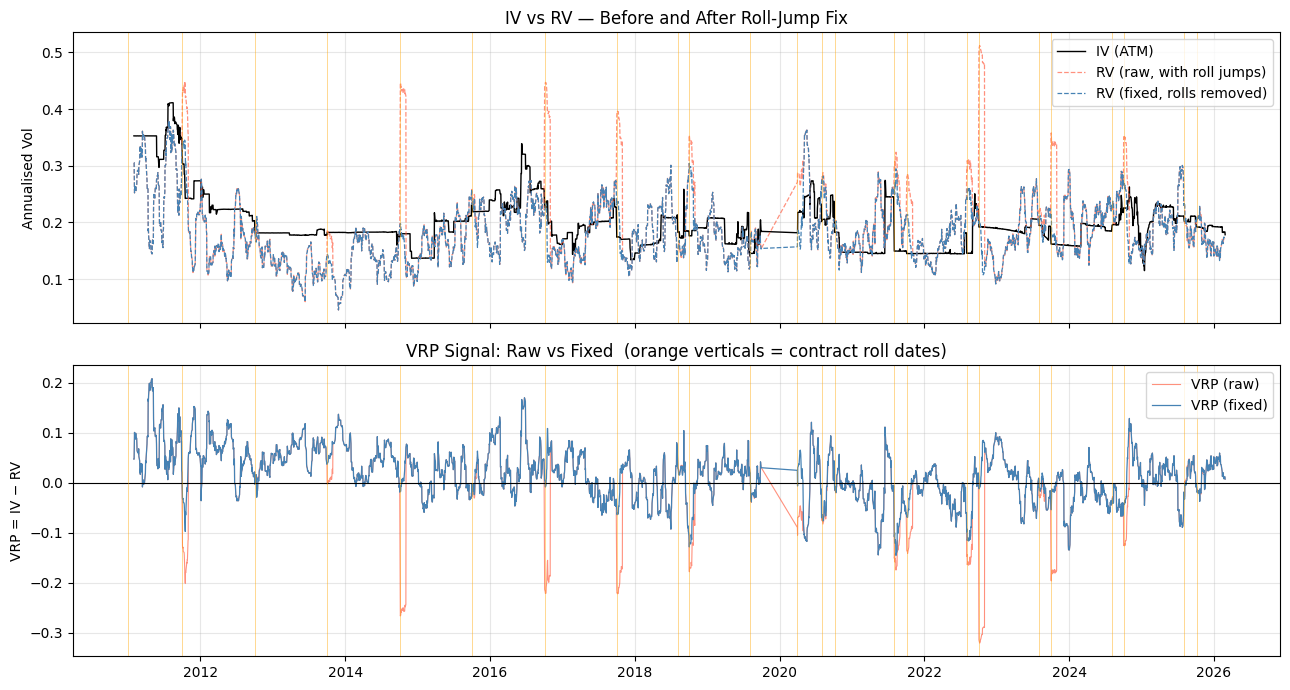

Raw   — Mean VRP: 0.0073   % days IV > RV: 62.1%
Fixed — Mean VRP: 0.0173   % days IV > RV: 64.9%


In [7]:

# ── Fix roll-date jumps: set log_ret to NaN on contract roll days ──────────
front_fixed = front.copy()

# Mark dates where the active expiration contract changes
rollover_mask = front_fixed["expiration"] != front_fixed["expiration"].shift(1)

# Null out the log-return on roll dates to prevent the cross-contract
# calendar spread from polluting the rolling RV window
front_fixed["log_ret_clean"] = front_fixed["log_ret"].where(~rollover_mask, np.nan)

# Recompute RV (require at least 15 valid observations in the window)
front_fixed["RV_21d_clean"] = (
    front_fixed["log_ret_clean"]
    .rolling(WINDOW, min_periods=15)
    .std() * np.sqrt(252)
)
front_fixed["VRP_clean"] = front_fixed["atm"] - front_fixed["RV_21d_clean"]

# ── Compare RV and VRP before vs after the roll-jump fix ──────────────────
fig, axes = plt.subplots(2, 1, figsize=(13, 7), sharex=True)

plot2 = front_fixed.dropna(subset=["RV_21d", "RV_21d_clean"])

axes[0].plot(plot2["date"], plot2["atm"],           label="IV (ATM)",                   color="black",     linewidth=1)
axes[0].plot(plot2["date"], plot2["RV_21d"],         label="RV (raw, with roll jumps)",  color="tomato",    linewidth=0.9, linestyle="--", alpha=0.7)
axes[0].plot(plot2["date"], plot2["RV_21d_clean"],   label="RV (fixed, rolls removed)",  color="steelblue", linewidth=0.9, linestyle="--")
axes[0].set_ylabel("Annualised Vol")
axes[0].set_title("IV vs RV — Before and After Roll-Jump Fix")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Mark roll dates with vertical lines
for d in front_fixed.loc[rollover_mask, "date"]:
    axes[0].axvline(d, color="orange", linewidth=0.5, alpha=0.6)

axes[1].plot(plot2["date"], plot2["VRP"],        label="VRP (raw)",   color="tomato",    linewidth=0.8, alpha=0.7)
axes[1].plot(plot2["date"], plot2["VRP_clean"],  label="VRP (fixed)", color="steelblue", linewidth=0.9)
axes[1].axhline(0, color="black", linewidth=0.8)
axes[1].set_ylabel("VRP = IV − RV")
axes[1].set_title("VRP Signal: Raw vs Fixed  (orange verticals = contract roll dates)")
axes[1].legend()
axes[1].grid(alpha=0.3)
for d in front_fixed.loc[rollover_mask, "date"]:
    axes[1].axvline(d, color="orange", linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()

print(f"Raw   — Mean VRP: {plot2['VRP'].mean():.4f}   % days IV > RV: {(plot2['VRP']>0).mean()*100:.1f}%")
print(f"Fixed — Mean VRP: {plot2['VRP_clean'].mean():.4f}   % days IV > RV: {(plot2['VRP_clean']>0).mean()*100:.1f}%")



## Volatility Risk Premium (VRP) Strategy — Summary

### Overview
This strategy exploits the well-documented tendency for **implied volatility (IV) to systematically exceed realized volatility (RV)** in commodity options markets. The difference, known as the **Volatility Risk Premium (VRP)**, represents the compensation that option buyers pay sellers for bearing volatility uncertainty.

$$\text{VRP}_t = \text{IV}_t - \text{RV}_t$$

---

### Data
- **Source**: Nasdaq Data Link `AR/IVM` — daily IV surface parameters for wheat futures options (CBOT/ICE, exchange code `NYX`, futures code `W`)
- **IV**: The `atm` column gives the **at-the-money Black-76 implied volatility** directly — no Black-Scholes computation is needed
- **RV**: Computed from the **futures price log-returns** (not option prices) using a 21-trading-day rolling window, annualised by $\sqrt{252}$
- **Contracts**: 28 distinct expirations (Oct `V` and Dec `Z` each year), spanning 2011–2028; each contract is active for roughly 1.5–2 years

---

### Construction of the Front-Month Series
On each date, the **nearest expiration with more than 30 days remaining** is selected as the "active" contract. This avoids the distortions that arise in the final month before expiration (widening bid-ask spreads, pin risk, etc.).

**Roll-date correction**: When the active contract switches, the futures prices of two different delivery months are being compared, introducing a spurious jump (calendar spread) in the log-return series. This inflates RV artificially around every roll date. The fix is to **set the log-return to NaN on each roll day**, so the rolling RV window ignores the jump.

| | Raw (with jumps) | Fixed (jumps removed) |
|---|---|---|
| Mean VRP | 0.0073 | **0.0173** |
| % days IV > RV | 62.1% | **64.9%** |

---

### Trading Signal
| Condition | Signal | Action |
|---|---|---|
| $\text{VRP} > 0$ (IV > RV) | Short volatility | Sell ATM straddle (delta-hedged) |
| $\text{VRP} < 0$ (IV < RV) | Long volatility | Buy ATM straddle |

---

### Caveats
- The backtest P&L is expressed in **volatility units** (not dollars), so the Sharpe ratio is an upper bound — real execution involves transaction costs, bid-ask spread on options, continuous delta-hedging costs, and margin requirements.
- The `rr25` and `fly25` columns (25-delta risk reversal and butterfly) can be used to further refine the signal by incorporating **skew** and **kurtosis** premia.
- Wheat options are subject to **seasonal volatility patterns** (harvest cycles), which a more sophisticated strategy would account for.
